In [2]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Initiate directories:

In [3]:
ROOT_DIR = os.getcwd() + '/../'
try:
    with open (ROOT_DIR + '/configuration.yml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
DATA_DIR = ROOT_DIR + config['data']['final'] + '/'
cities = pd.read_csv(ROOT_DIR + config['cities'])

### Cities information, eg. to loop over city names:

* **ALE:**	Alert, Canada
* **ABZ:**	Annaberg-Buchholz, Germany
* **ASP:**	Aspvreten, Sweden
* **BOT:**	Botsalano, South Africa
* **BSL:**	Bösel (Südoldenburg), Germany
* **EGB:**	Egbert, Canada
* **HEL:**	Helsinki, Finland
* **HPB:**	Hohenpeissenberg, Germany
* **HYY:**	Hyytiälä, Finland
* **KCE:**	Kosetice, Czech Republic
* **KPZ:**	K-Puszta, Hungary
* **MHD:**	Mace Head, Ireland
* **MAR:**	Marikana, South Africa
* **MLP:**	Melpitz, Germany
* **NAN:**	Nanjing, China
* **NEU:**	Neuglobsow, Germany
* **SAO:**	São Paulo, Brazil
* **SCH:**	Schauinsland, Germany
* **SGP:**	Southern Great Plains, Oklahoma, US
* **VIE:**	Vielsalm, Belgium
* **VAR:**	Värriö, Finland
* **WAL:**	Waldhof, Germany

In [33]:
cities.city.unique()

array(['ALE', 'ABZ', 'ASP', 'BOT', 'BSL', 'EGB', 'HEL', 'HPB', 'HYY',
       'KCE', 'KPZ', 'MHD', 'MAR', 'MLP', 'NAN', 'NEU', 'SAO', 'SCH',
       'SGP', 'VIE', 'VAR', 'WAL'], dtype=object)

In [4]:
city = cities.city[6]
city

'HEL'

### Open data file:

In [5]:
df = pd.read_csv(DATA_DIR + city + '.csv', index_col='date')
df.head()

,concentration,t,co
date,,,
2005-01-01,745.769167,271.50780,1.924972e-07
2005-01-02,374.991806,272.57120,1.903695e-07
2005-01-03,265.290294,272.60297,1.779340e-07
2005-01-04,304.682014,270.91785,2.032431e-07
2005-01-05,409.387986,272.37310,2.047700e-07


### Visualizations:

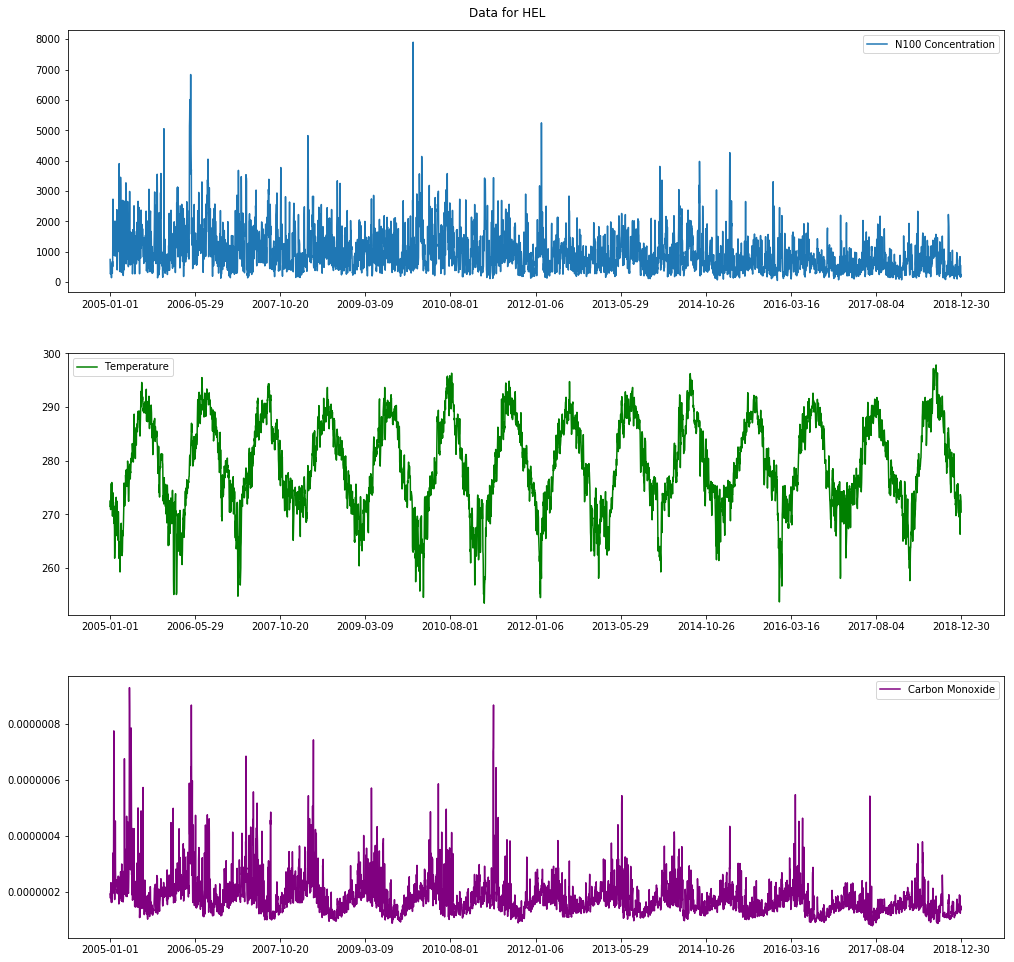

In [30]:
idx = df.shape[0]
step = int(idx / 10)
xticks = pd.Series(df.index).iloc[list(range(0,idx,step))]

fig, ax = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(14)

ax[0].plot(df.index[:idx], df.concentration[:idx], label='N100 Concentration')
ax[1].plot(df.index[:idx], df.t[:idx], label='Temperature', c='green')
ax[2].plot(df.index[:idx], df.co[:idx], label='Carbon Monoxide', c='purple')

for i in range(3):
    ax[i].legend()
    ax[i].set_xticks(xticks)

fig.tight_layout(pad=4)
fig.suptitle('Data for '+city);